### Import block

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant

from sklearn.utils import class_weight
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

from math import log10, sqrt

%matplotlib inline

In [2]:
# Check for available GPU.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Function definitions

In [3]:
# Loader functions
# Inspiration: https://towardsdatascience.com/writing-custom-keras-generators-fe815d992c5a

def get_input(path):
    # Load array.
    t_input = np.load(path)
    
    # Pad to even number of pixels
    #t_input = np.pad(t_input, [(0,0),(0,1),(0,1)])
    # Resize to include a channel dimension.
    #t_input = tf.expand_dims(t_input, axis = -1)
    
    ## Put channel dim at the end.
    #t_input = np.moveaxis(t_input, 1, -1)
    
    return t_input

def get_output(path):
    # Load array.
    t_output = np.load(path)
    
    # Pad to even number of pixels
    #t_output = np.pad(t_output, [(0,0),(0,1),(0,1)])
    # Resize to include a channel dimension.
    #t_output = tf.expand_dims(t_output, axis = -1)
    
    ## Put channel dim at the end.
    #t_output = np.moveaxis(t_output, 1, -1)
    return t_output

def data_generator(samples, batch_size = 64):
    
    while True:
        # Select files (paths/indices) for the batch
        batch_samples  = np.random.choice(a = samples.index, 
                                      size = batch_size)
        batch_input  = []
        batch_output = [] 

        # Read in each input, perform preprocessing and get labels
        for sample in batch_samples:
          input = get_input(samples.loc[sample].features)
          output = get_output(samples.loc[sample].labels)

          batch_input += [input]
          batch_output += [output]
        # Return a tuple of (input, output) to feed the network
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)
        
        yield(batch_x, batch_y)


In [4]:
### Source: https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
# Modified to 0-1 scale instead of 0-100
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 1
    max_pixel = 1
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr/100

### Load data

In [5]:
# Get data from one chip
m = pd.read_csv('V3_CLSTM_Dataset/train/meta.csv')
sample_input = np.load('V3_CLSTM_Dataset/train/features/119179.npy')
a = sample_input

# Pad to even number of pixels
#a = np.pad(sample_input, [(0,0),(0,1),(0,1)])
# Resize to include a channel dimension.
#a = tf.expand_dims(a, axis = -1)
# Resize to include a batch dimension.
#a = tf.expand_dims(a, axis = 0)


## Move channel axis to the end
#a = np.moveaxis(sample_input, 1, -1)

# Resize to include a batch dimension.
a = tf.expand_dims(a, axis = 0)

# Display shape for verification.
a.shape

TensorShape([1, 10, 32, 32, 4])

### Model assembly

In [6]:
# Inspired by: https://keras.io/examples/vision/conv_lstm/?fbclid=IwAR1QSJmF0bcz5pklHDHwl4mUi8inzHN4m8Zk6OpvVJizqDDv2-MKMq3LlJ8

inputs = layers.Input(shape=((10,32,32,3)))
x = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(5, 5),
    padding='same',
    return_sequences=False,
    activation='relu'
)(inputs)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(3, 3),
    padding='same',
    return_sequences=False,
    activation='relu'
)(tf.expand_dims(x, axis = 1))
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(1, 1),
    padding='same',
    return_sequences=False,
    activation='relu'
)(tf.expand_dims(x, axis = 1))
outputs = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation='sigmoid', padding='same'
)(tf.expand_dims(x, axis = 1))

In [7]:
forecast_model = tf.keras.Model(inputs, outputs, name="Conv_LSTM")

In [9]:
# Verify output shape.
forecast_model.predict(a).shape

In [10]:
# Compile model.
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss_fn = tf.keras.losses.BinaryCrossentropy()
forecast_model.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy'])

In [11]:
# Data loaders.
batch_size = 64
meta_t = pd.read_csv('V3_CLSTM_Dataset/train/meta.csv')
meta_v = pd.read_csv('V3_CLSTM_Dataset/val/meta.csv')
#t_gen = data_generator(meta_t, batch_size = batch_size)
#v_gen = data_generator(meta_v, batch_size = batch_size)

In [12]:
# Trying new approach to build dataset.
x_train, y_train, x_val, y_val = [],[],[],[]

# Iterate over dataset.
for x in range(0,len(meta_t)):
    x_train.append(np.load(meta_t.iloc[x].features))
    y_train.append(np.load(meta_t.iloc[x].labels))
for x in range(0,len(meta_v)):
    x_val.append(np.load(meta_v.iloc[x].features))
    y_val.append(np.load(meta_v.iloc[x].labels))
    
# Stack layers.
x_train = np.stack(x_train)
y_train = np.stack(y_train)
x_val = np.stack(x_val)
y_val = np.stack(y_val)

# Convert values > 1 to 1.
x_train = np.minimum(x_train,1)
y_train = np.minimum(y_train,1)
x_val = np.minimum(x_val,1)
y_val = np.minimum(y_val,1)

# Add channel dims to labels.
y_train = tf.expand_dims(y_train, axis = -1).numpy()
y_val = tf.expand_dims(y_val, axis = -1).numpy()

In [13]:
## Experiment: modify output to single frame.
y_train = y_train[:,:1]
y_val = y_val[:,:1]

In [24]:
## Get rid of defo channel.
#x_train = np.stack([x_train[:,:,:,:,0], x_train[:,:,:,:,2], x_train[:,:,:,:,3]], axis = -1)
#x_val = np.stack([x_val[:,:,:,:,0], x_val[:,:,:,:,2], x_val[:,:,:,:,3]], axis = -1)

In [25]:
# Solution for problem with class_weights not working with 3D outputs in tensorflow.
# From: https://github.com/keras-team/keras/issues/3653
def generate_sample_weights(training_data, class_weights): 
    #replaces values for up to 3 classes with the values from class_weights#
    sample_weights = [np.where(y==0,class_weights[0],
                        np.where(y==1,class_weights[1],
                        y)) for y in training_data]
    return np.asarray(sample_weights)

In [26]:
# Get class weights for weighted binary cross entropy loss.
weights = class_weight.compute_class_weight('balanced',
                                            classes = [0,1],
                                            y = y_train.flatten())
# Examine weights.
weights

array([ 0.50664783, 38.10623077])

In [27]:
calculated_sample_weights = generate_sample_weights(y_train, weights)

In [28]:
# Move numpy objects to tensors.
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
x_val = tf.convert_to_tensor(x_val)
y_val = tf.convert_to_tensor(y_val)
calculated_sample_weights = tf.convert_to_tensor(calculated_sample_weights)

In [29]:
# Validate weight matrix shape.
calculated_sample_weights.shape == y_train.shape

True

In [30]:
# Params
batch_size = 4

# Adding callbacks.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2)

# Train model.
forecast_model.fit(x_train,
                   y_train,
                   epochs = 100, 
                   verbose = 1, 
                   batch_size = batch_size,
                   validation_data = (x_val, y_val),
                   callbacks = [early_stopping, reduce_lr],
                   sample_weight = calculated_sample_weights
                  )

Epoch 1/100
2474/2474 [==============================] - 203s 80ms/step - loss: 0.5069 - accuracy: 0.7960 - val_loss: 0.2851 - val_accuracy: 0.9390 - lr: 1.0000e-04
Epoch 2/100
2474/2474 [==============================] - 197s 80ms/step - loss: 0.4558 - accuracy: 0.8420 - val_loss: 0.3425 - val_accuracy: 0.8988 - lr: 1.0000e-04
Epoch 3/100
2474/2474 [==============================] - 197s 79ms/step - loss: 0.4445 - accuracy: 0.8412 - val_loss: 0.5241 - val_accuracy: 0.7926 - lr: 1.0000e-04
Epoch 4/100
2474/2474 [==============================] - 197s 79ms/step - loss: 0.4288 - accuracy: 0.8433 - val_loss: 0.3815 - val_accuracy: 0.8748 - lr: 1.0000e-05
Epoch 5/100
2474/2474 [==============================] - 197s 80ms/step - loss: 0.4254 - accuracy: 0.8396 - val_loss: 0.3176 - val_accuracy: 0.8827 - lr: 1.0000e-05
Epoch 6/100
2474/2474 [==============================] - 202s 81ms/step - loss: 0.4212 - accuracy: 0.8405 - val_loss: 0.3479 - val_accuracy: 0.8773 - lr: 1.0000e-06
Epoch 7/10

In [31]:
# Save trained model.
forecast_model.save('Models/W04')

INFO:tensorflow:Assets written to: Models/W04\assets


INFO:tensorflow:Assets written to: Models/W04\assets


In [ ]:
forecast_model = tf.keras.models.load_model('Models/W04')

### Examing single-frame predictions

In [32]:
# Select a random example from the validation dataset.
example = np.random.choice(range(len(x_val)), size=1)[0]

# Pick the first/last ten frames from the example.
feature_frames = x_val[example, ...]
label_frames = y_val[example, ...]
pred_frames = []

# Predict a new set of 10 frames.
# Extract the model's prediction and post-process it.
new_prediction = forecast_model.predict(np.expand_dims(feature_frames, axis=0))
new_prediction = np.squeeze(new_prediction, axis=0)
predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
pred_frames.append(predicted_frame)
    

# Extend the set of prediction frames.
pred_frames = np.concatenate(pred_frames)

1/1 [==============================] - 0s 423ms/step


In [33]:
# Shape verification.
label_frames.shape == pred_frames.shape

True

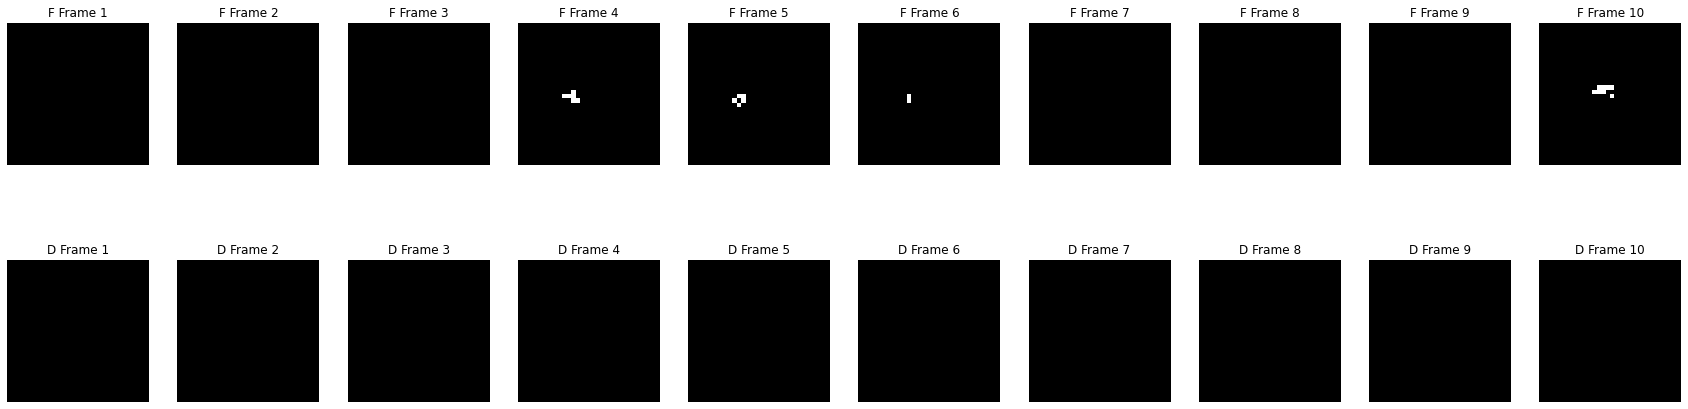

In [34]:
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(30, 8))

# Plot the fire frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(feature_frames[idx][:,:,:1]), cmap="gray")
    ax.set_title(f"F Frame {idx + 1}")
    ax.axis("off")

# Plot the deforestation frames.
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(feature_frames[idx][:,:,1:2]), cmap="gray")
    ax.set_title(f"D Frame {idx + 1}")
    ax.axis("off")
    
# Display the figure.
plt.show()

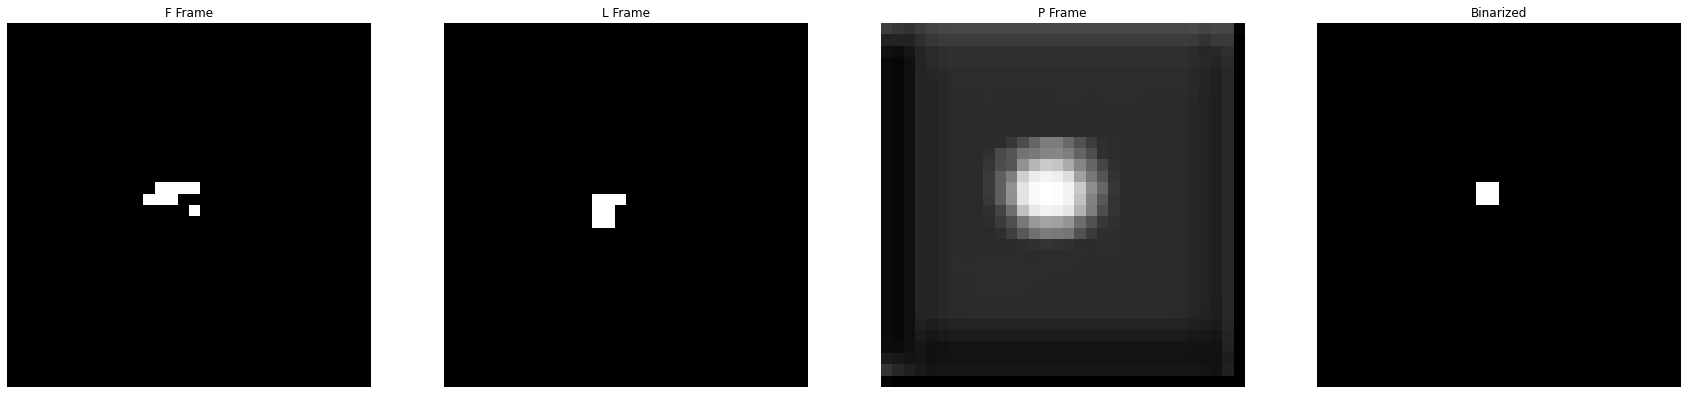

In [35]:
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(1, 4, figsize=(30, 8))

# Plot the last feature frame.
axes[0].imshow(np.squeeze(feature_frames[9][:,:,:1]), cmap="gray")
axes[0].set_title(f"F Frame")
axes[0].axis("off")

# Plot the label frame.
axes[1].imshow(np.squeeze(label_frames[0]), cmap="gray")
axes[1].set_title(f"L Frame")
axes[1].axis("off")
    
# Plot the predicted frame.
axes[2].imshow(np.squeeze(pred_frames[0]), cmap="gray")
axes[2].set_title(f"P Frame")
axes[2].axis("off")

# Plot binarized prediction.
axes[3].imshow(np.squeeze(np.where(pred_frames > 0.85, 1, 0)), cmap="gray")
axes[3].set_title(f"Binarized")
axes[3].axis("off")

# Display the figure.
plt.show()

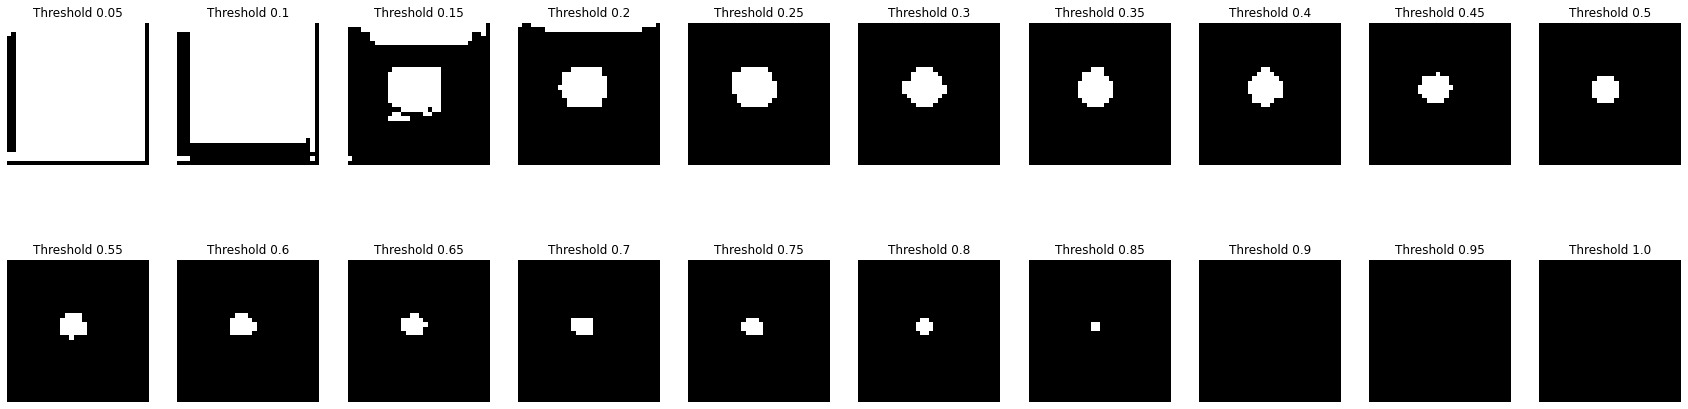

In [36]:
# Construct a figure to show all prediction thresholds.
fig, axes = plt.subplots(2, 10, figsize=(30, 8))

# Plot the frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(np.where(pred_frames > ((idx + 1) * 0.05), 1, 0)), cmap="gray")
    ax.set_title(f"Threshold {round((idx + 1) * 0.05, 2)}")
    ax.axis("off")

for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(np.where(pred_frames > ((idx + 11) * 0.05), 1, 0)), cmap="gray")
    ax.set_title(f"Threshold {round((idx + 11) * 0.05, 2)}")
    ax.axis("off")
    
# Display the figure.
plt.show()

In [37]:
# Get first sample IoU
thresholds = [x/100 for x in range(0,105,5)]
ious = []
for t in thresholds:
    intersection = np.logical_and(np.where(pred_frames > t, 1, 0), label_frames[0])
    union = np.logical_or(np.where(pred_frames > t, 1, 0), label_frames[0])
    iou_score = np.sum(intersection) / np.sum(union)
    ious.append((t,iou_score))
ious

[(0.0, 0.0068359375),
 (0.05, 0.007709251101321586),
 (0.1, 0.009126466753585397),
 (0.15, 0.027888446215139442),
 (0.2, 0.05223880597014925),
 (0.25, 0.09090909090909091),
 (0.3, 0.109375),
 (0.35, 0.125),
 (0.4, 0.14),
 (0.45, 0.18421052631578946),
 (0.5, 0.21875),
 (0.55, 0.20689655172413793),
 (0.6, 0.18518518518518517),
 (0.65, 0.20833333333333334),
 (0.7, 0.23809523809523808),
 (0.75, 0.2631578947368421),
 (0.8, 0.26666666666666666),
 (0.85, 0.2222222222222222),
 (0.9, 0.0),
 (0.95, 0.0),
 (1.0, 0.0)]

### Get IoU for full prediction set.

In [38]:
# Predict on everything.
all_preds = forecast_model.predict(x_val)

60/60 [==============================] - 6s 91ms/step


In [39]:
# Get IoU.
thresholds = [x/100 for x in range(0,105,5)]
ious = []
for t in thresholds:
    intersection = np.logical_and(np.where(all_preds > t, 1, 0), y_val)
    union = np.logical_or(np.where(all_preds > t, 1, 0), y_val)
    iou_score = np.sum(intersection) / np.sum(union)
    ious.append((t,iou_score))
ious

[(0.0, 0.008262786704784437),
 (0.05, 0.008901590677477957),
 (0.1, 0.009757206958018317),
 (0.15, 0.011307718469102104),
 (0.2, 0.01578332098460525),
 (0.25, 0.03142322864900866),
 (0.3, 0.04749338155393981),
 (0.35, 0.056277946511431705),
 (0.4, 0.060810116482201255),
 (0.45, 0.06474244993039187),
 (0.5, 0.06871426442560334),
 (0.55, 0.0716056790406692),
 (0.6, 0.07353985092873763),
 (0.65, 0.07473623802586854),
 (0.7, 0.07587713821950307),
 (0.75, 0.07527070017219742),
 (0.8, 0.0726136303273899),
 (0.85, 0.06624663288134046),
 (0.9, 0.05050861598690755),
 (0.95, 0.020176045890614183),
 (1.0, 0.0)]

In [40]:
# Get MSE.
mses = [mean_squared_error(all_preds[x], y_val[x].numpy()) for x in range(0,len(all_preds))]
mean_squared_error(all_preds, y_val.numpy())

0.07210368866621648

In [41]:
## Get SSIM if masking is applied.
## Calculation seems to be skewed and giving unreasonably high scores with masking applied.
#thresholds = [x/100 for x in range(0,105,5)]
#masked_ssims = []
#for t in thresholds:
#    t_ssim = [ssim(np.where(all_preds[x][0] > t, 1, 0), y_val[x][0].numpy(), multichannel = True) for x in range(0,len(all_preds))]
#    t_ssim2 = sum(t_ssim) / len(t_ssim)
#    masked_ssims.append((t,t_ssim2))
#masked_ssims

In [42]:
# Get Peak Signal-to-Noise Ratio (PSNR)
psnrs = [PSNR(all_preds[x], y_val[x][0].numpy()) for x in range(0,len(all_preds))]
set_psnr = sum(psnrs) / len(psnrs)
set_psnr

0.12160379529264818

In [43]:
# Get raw mean SSIM
ssims = [ssim(all_preds[x][0], y_val[x][0].numpy(), multichannel = True) for x in range(0,len(all_preds))]
mean_raw_ssim = sum(ssims) / len(ssims)
mean_raw_ssim

C:\Users\covad\anaconda3\lib\site-packages\skimage\metrics\_structural_similarity.py:107: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ch_result = structural_similarity(im1[..., ch],


0.015064661098911013

In [44]:
type(y_val[x][0].numpy())

numpy.ndarray

In [45]:
# Get DataFrame of all prediction grades.
rows = []
for s in range(0,len(all_preds)): 
    thresholds = [x/100 for x in range(0,105,5)]
    t_ious = []
    for t in thresholds:
        intersection = np.logical_and(np.where(all_preds[s] > t, 1, 0), y_val[s])
        union = np.logical_or(np.where(all_preds[s] > t, 1, 0), y_val[s])
        if np.sum(union) > 0:
            iou_score = np.sum(intersection) / np.sum(union)
        else:
            iou_score = 0
        t_ious.append(iou_score)
    rows.append(t_ious)
iou_df = pd.DataFrame(rows)
iou_df['ssim'] = ssims
iou_df['mse'] = mses
iou_df['psnr'] = psnrs

### Examining Good Predictions

0.11300476504911074

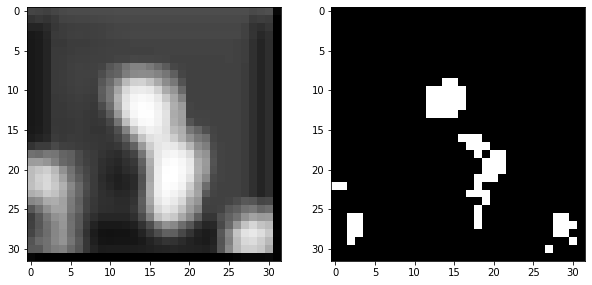

In [46]:
# Examining the best SSIM
x = iou_df.sort_values(by = 'ssim', ascending = False).index[0]
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(all_preds[x][0], cmap="gray")
axes[1].imshow(y_val[x][0].numpy(), cmap="gray")
ssims[x]

0.017745037022834264

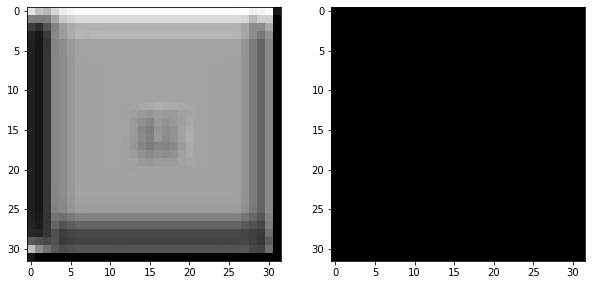

In [47]:
# Examining the best MSE
x = iou_df.sort_values(by = 'mse', ascending = True).index[0]
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(all_preds[x][0], cmap="gray")
axes[1].imshow(y_val[x][0].numpy(), cmap="gray")
mses[x]

In [48]:
iou_df.max()

0       0.131836
1       0.140479
2       0.141066
3       0.149830
4       0.160661
5       0.217391
6       0.305085
7       0.500000
8       0.666667
9       0.500000
10      0.571429
11      0.666667
12      0.583333
13      1.000000
14      1.000000
15      0.551020
16      0.550000
17      0.777778
18      0.500000
19      0.500000
20      0.000000
ssim    0.113005
mse     0.382509
psnr    0.175092
dtype: float64

In [49]:
iou_df[19].sort_values(ascending = False)

443     0.500000
1383    0.428571
755     0.388889
608     0.311475
1327    0.266667
          ...   
643     0.000000
642     0.000000
641     0.000000
640     0.000000
1901    0.000000
Name: 19, Length: 1902, dtype: float64

In [50]:
iou_df[14].sort_values(ascending = False)[:5]

412     1.000000
596     0.800000
1005    0.777778
731     0.750000
598     0.571429
Name: 14, dtype: float64

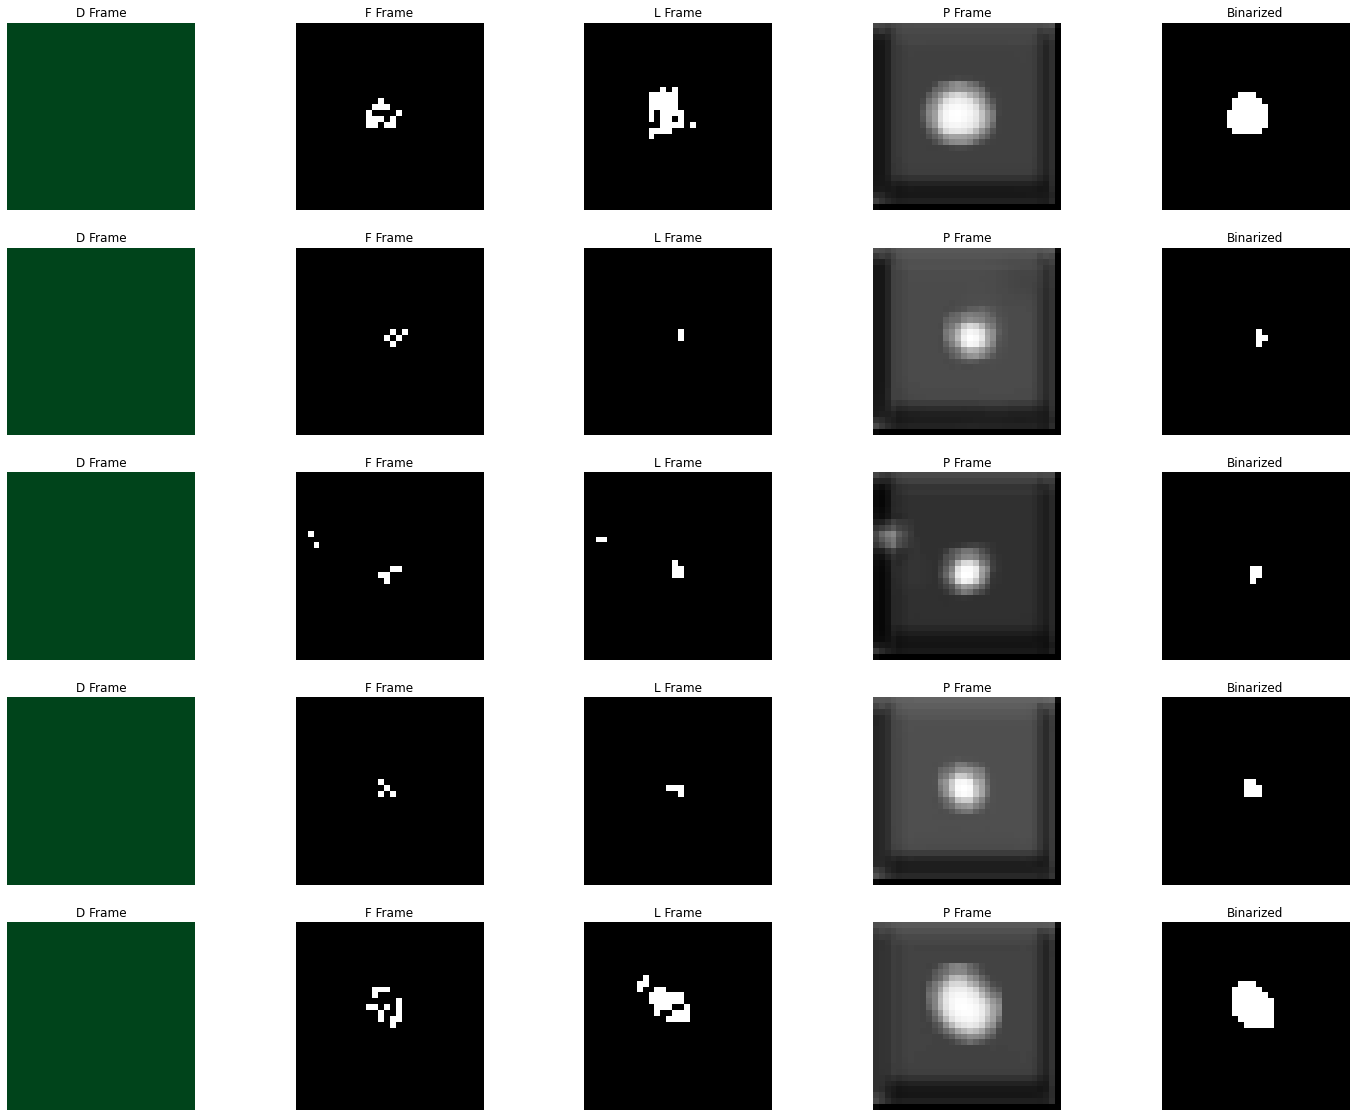

In [51]:
# Construct a figure for the original and new frames.
fig, all_axes = plt.subplots(5, 5, figsize=(25, 20))

# List of samples to check:
tgts = list(iou_df[15].sort_values(ascending = False)[:5].index)
x = -1

for axes in all_axes:
    x += 1
    
    # Plot deforestaion.
    axes[0].imshow(np.squeeze(x_val[tgts[x]][9][:,:,1:2]), cmap="Greens_r")
    axes[0].set_title(f"D Frame")
    axes[0].axis("off")
    
    # Plot the last feature frame.
    axes[1].imshow(np.squeeze(x_val[tgts[x]][9][:,:,:1]), cmap="gray")
    axes[1].set_title(f"F Frame")
    axes[1].axis("off")

    # Plot the label frame.
    axes[2].imshow(np.squeeze(y_val[tgts[x]]), cmap="gray")
    axes[2].set_title(f"L Frame")
    axes[2].axis("off")

    # Plot the predicted frame.
    axes[3].imshow(np.squeeze(all_preds[tgts[x]]), cmap="gray")
    axes[3].set_title(f"P Frame")
    axes[3].axis("off")

    # Plot binarized prediction.
    axes[4].imshow(np.squeeze(np.where(all_preds[tgts[x]] > 0.75, 1, 0)), cmap="gray")
    axes[4].set_title(f"Binarized")
    axes[4].axis("off")

# Display the figure.
plt.show()

### Examining Pretty Bad Predictions

In [52]:
iou_df[iou_df[19] > 0.02][19].sort_values()

1333    0.021978
1144    0.022222
1827    0.022472
885     0.023810
1341    0.024194
          ...   
1327    0.266667
608     0.311475
755     0.388889
1383    0.428571
443     0.500000
Name: 19, Length: 78, dtype: float64

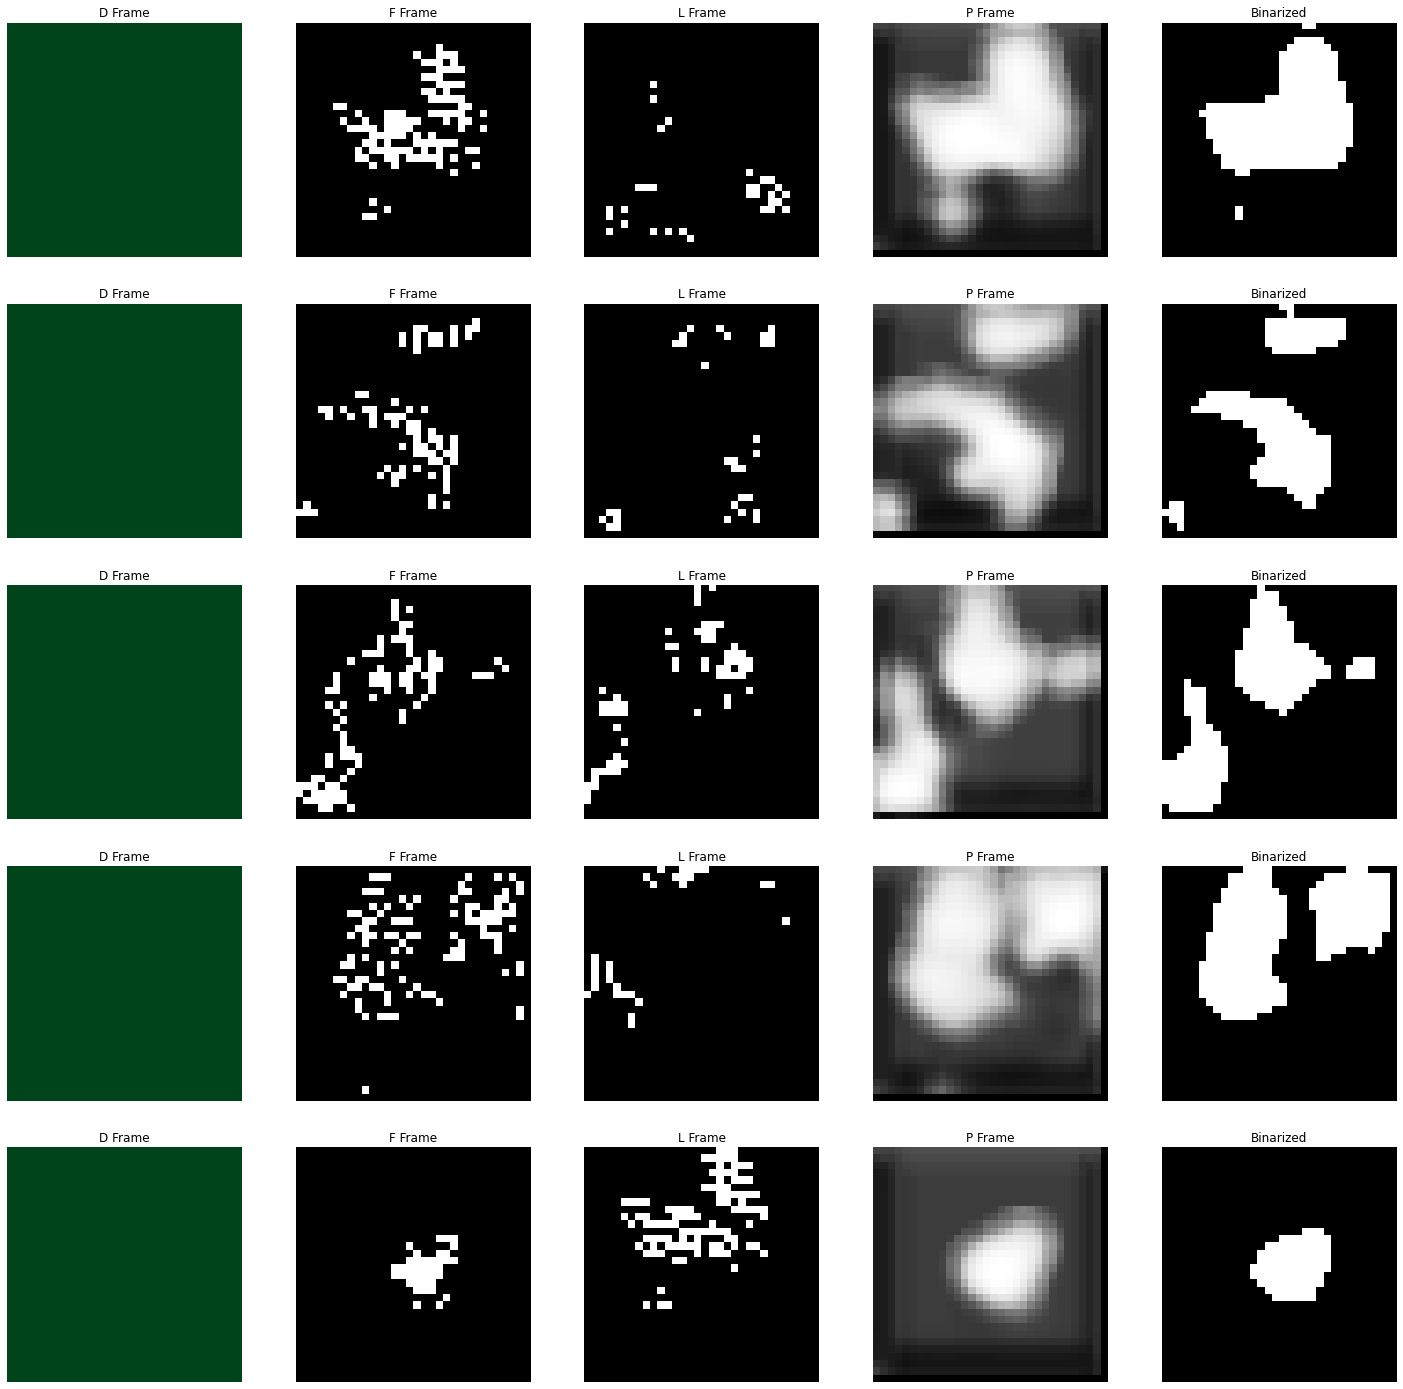

In [53]:
# Construct a figure for the original and new frames.
fig, all_axes = plt.subplots(5, 5, figsize=(25, 25))

# List of samples to check:
tgts = list(iou_df[iou_df[19] > 0.02][19].sort_values()[:5].index)
x = -1

for axes in all_axes:
    x += 1
    
    # Plot deforestaion.
    axes[0].imshow(np.squeeze(x_val[tgts[x]][9][:,:,1:2]), cmap="Greens_r")
    axes[0].set_title(f"D Frame")
    axes[0].axis("off")
    
    # Plot the last feature frame.
    axes[1].imshow(np.squeeze(x_val[tgts[x]][9][:,:,:1]), cmap="gray")
    axes[1].set_title(f"F Frame")
    axes[1].axis("off")

    # Plot the label frame.
    axes[2].imshow(np.squeeze(y_val[tgts[x]]), cmap="gray")
    axes[2].set_title(f"L Frame")
    axes[2].axis("off")

    # Plot the predicted frame.
    axes[3].imshow(np.squeeze(all_preds[tgts[x]]), cmap="gray")
    axes[3].set_title(f"P Frame")
    axes[3].axis("off")

    # Plot binarized prediction.
    axes[4].imshow(np.squeeze(np.where(all_preds[tgts[x]] > 0.75, 1, 0)), cmap="gray")
    axes[4].set_title(f"Binarized")
    axes[4].axis("off")

# Display the figure.
plt.show()

In [54]:
# Print all set metrics again for ease of gathering.
print('ssim',mean_raw_ssim)
print('psnr',set_psnr)
print('mse',mean_squared_error(all_preds, y_val.numpy()))
ious

ssim 0.015064661098911013
psnr 0.12160379529264818
mse 0.07210368866621648


[(0.0, 0.008262786704784437),
 (0.05, 0.008901590677477957),
 (0.1, 0.009757206958018317),
 (0.15, 0.011307718469102104),
 (0.2, 0.01578332098460525),
 (0.25, 0.03142322864900866),
 (0.3, 0.04749338155393981),
 (0.35, 0.056277946511431705),
 (0.4, 0.060810116482201255),
 (0.45, 0.06474244993039187),
 (0.5, 0.06871426442560334),
 (0.55, 0.0716056790406692),
 (0.6, 0.07353985092873763),
 (0.65, 0.07473623802586854),
 (0.7, 0.07587713821950307),
 (0.75, 0.07527070017219742),
 (0.8, 0.0726136303273899),
 (0.85, 0.06624663288134046),
 (0.9, 0.05050861598690755),
 (0.95, 0.020176045890614183),
 (1.0, 0.0)]

In [55]:
### Alert on completion
from IPython.display import Audio, display
display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))